In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

import gym

In [2]:
# Neural Network for both the actor and the critic.
class ActorCriticNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ActorCriticNN, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )
     
    def forward(self, observation):
        return self.network(observation)

/home/elisio/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Possible actions: 4
Possible states: Box(8,)


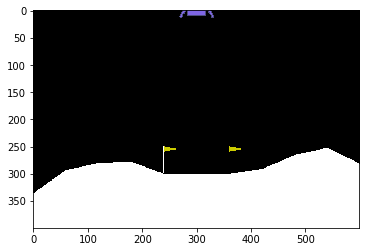

In [3]:
env = gym.make('LunarLander-v2')

print("Possible actions:", env.action_space.n)
print("Possible states:", env.observation_space)

env.reset()
plt.imshow(env.render("rgb_array"))

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device to be used:", device)

Device to be used: cuda


In [5]:
# Define the actor and the critic networks
# The actor will have as number of outputs the number of actions the agent can take in the env.
actor = ActorCriticNN(env.observation_space.shape[0], env.action_space.n).to(device)

# The critic will have as number of outputs only 1 as it will update the Q value function.
critic = ActorCriticNN(env.observation_space.shape[0], 1).to(device)

In [6]:
# Hyperparameters
learning_rate = 0.00001
alpha = 0.99 # step-size
print_rate = 50 # rate that the output will be printed

In [7]:
# Adam optimizer with the same learning_rate for both networks
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=learning_rate)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=learning_rate)

In [8]:
# This function is the core of the Actor-Critic method.
def update_networks(new_state, reward, done, state, action_prob):
    # create a not_done to make the math easier
    not_done = 1 - int(done)
    
    # transform to pytorch tensors
    new_state = torch.tensor(new_state, dtype=torch.float32, device=device)
    reward = torch.tensor(reward, dtype=torch.float32, device=device)

    # calculate the Q-values, through the critic network, given the current state and the new state
    qvalue = critic(state)
    qvalue_new = critic(new_state)
    
    # calculate td_error, on a terminal state only the value of reward is considered (not_done == 0)
    # on a non-terminal state both the reward and the discounted reward of the best action of the next state are considered (not_done == 1)
    td_error = (reward + alpha*qvalue_new*not_done) - qvalue
    # objective function to maximise
    objective = -1*torch.log(action_prob)*td_error
    
    # calculate both set of gradients
    (torch.pow(td_error, 2) + objective).backward()
    
    # update parameters for both networks
    actor_optimizer.step()
    critic_optimizer.step()
    
    # set gradients to zero
    actor_optimizer.zero_grad()
    critic_optimizer.zero_grad()

In [9]:
print_rate = 50 # rate that the output will be printed

rewards_history = []

def train(env, n_episodes=30):
    
    for episode in range(1, n_episodes+1):
        done = False
        state = env.reset()
        rewards_episode = 0
        
        while not done:
            # convert state to a Pytorch tensor
            state = torch.tensor(state, dtype=torch.float32, device=device)
            
            # calculate the probabilities of actions returned from the actor network (given the state)
            action_probs = F.softmax(actor(state))
            
            # sample an action of a categorical distribution of the probabilities of actions
            # https://pytorch.org/docs/stable/distributions.html
            action = torch.distributions.Categorical(action_probs).sample()
            
            new_state, reward, done, info = env.step(int(action))
            
            # the networks are updated at each step as we're using a TD learning algorithm
            update_networks(new_state, reward, done, state, action_probs[int(action)])
            
            state = new_state
            rewards_episode += reward
        
        rewards_history.append(rewards_episode)
        
        if episode%print_rate == 0:
            print("Episode {} \t rewards(mean):{:.4f}".format(episode, np.mean(rewards_history[-print_rate:]))) 

In [10]:
train(env, 2500)

/home/elisio/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Episode 50 	 rewards(mean):-168.5970
Episode 100 	 rewards(mean):-176.9470
Episode 150 	 rewards(mean):-216.5230
Episode 200 	 rewards(mean):-191.3787
Episode 250 	 rewards(mean):-219.2413
Episode 300 	 rewards(mean):-214.7470
Episode 350 	 rewards(mean):-196.7667
Episode 400 	 rewards(mean):-156.7377
Episode 450 	 rewards(mean):-147.5315
Episode 500 	 rewards(mean):-118.8604
Episode 550 	 rewards(mean):-110.7086
Episode 600 	 rewards(mean):-114.5574
Episode 650 	 rewards(mean):-132.9430
Episode 700 	 rewards(mean):-89.8920
Episode 750 	 rewards(mean):-67.8145
Episode 800 	 rewards(mean):-71.4545
Episode 850 	 rewards(mean):-54.1840
Episode 900 	 rewards(mean):-22.0107
Episode 950 	 rewards(mean):-53.9027
Episode 1000 	 rewards(mean):-28.3567
Episode 1050 	 rewards(mean):-5.1179
Episode 1100 	 rewards(mean):-19.7729
Episode 1150 	 rewards(mean):23.1191
Episode 1200 	 rewards(mean):-32.7867
Episode 1250 	 rewards(mean):17.0409
Episode 1300 	 rewards(mean):17.6243
Episode 1350 	 rewards(

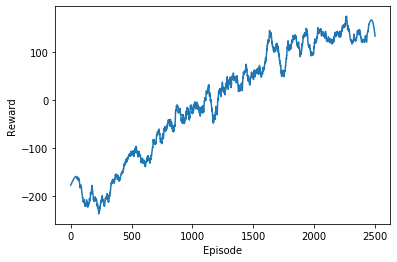

In [11]:
plt.plot(savgol_filter(rewards_history, 99, 3))
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

In [12]:
def validation_test(env, n_episodes=5):
# https://discuss.pytorch.org/t/model-eval-vs-with-torch-no-grad/19615/2
# https://stackoverflow.com/questions/55627780/evaluating-pytorch-models-with-torch-no-grad-vs-model-eval

    actor.eval() # set model to evaluation mode
    with torch.no_grad():
        for i in range(n_episodes):
            state = env.reset()
            done = False
            reward_sum = 0
            while not done:
                state = torch.tensor(state, dtype=torch.float32, device=device)
                action_probs = F.softmax(actor(state), dim=-1)

                action = int(torch.distributions.Categorical(action_probs).sample())

                state, reward, done, _ = env.step(action)
                reward_sum += reward
            print("Episode finished. Reward={:.4f}".format(reward_sum))


In [13]:
# play and record some episodes
from gym import wrappers
dir_videos = "./recordings-AC-lunarlander"

env_monitor = wrappers.Monitor(env, directory=dir_videos, force=True)

for _ in range(3):
    validation_test(env_monitor, n_episodes=3)
env_monitor.close()

Episode finished. Reward=-133.7221
Episode finished. Reward=222.4120
Episode finished. Reward=220.3992
Episode finished. Reward=233.6866
Episode finished. Reward=294.3479
Episode finished. Reward=248.6100
Episode finished. Reward=28.7816
Episode finished. Reward=218.1122
Episode finished. Reward=195.2243


In [14]:
# save models
torch.save(actor.state_dict(), "./agents/agent_actor_lunlander.pt")
torch.save(critic.state_dict(), "./agents/agent_critic_lunlander.pt")